<a href="https://colab.research.google.com/github/DigitalYogi/my-repo/blob/main/Copy_of_Intro_to_NLP_Week_11_Day_2_Lecture_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Deep NLP models

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis. The tutorial is heavily based on [Tensorflow text classification](https://www.tensorflow.org/text/tutorials/text_classification_rnn) tutorial available online. We will explain the notebook in depth and discuss code as we go along.

We will import the required packages here. Note that we are importing `tfds` here. Tensorflow datasets package has a dataset called IMDB Reviews. We will use this dataset to train a deep learning model for text classification. Here, given a review of a movie, we will predict whether the movie review is positive or negative.

In [2]:
import numpy as np

# We use Tensorflow Datasets package to load the data ****
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

# Step 1: Load and Preprocess the Dataset


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [4]:
# Define the dataset
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
# Get the train and test split from the dataset
train_dataset, test_dataset = dataset['train'], dataset['test']
# Print some details of the train_dataset
train_dataset.element_spec

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteEAA35K/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteEAA35K/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteEAA35K/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [5]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64 # hyper parameter

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# .shuffle(BUFFER_SIZE) --*** we want to randomize the sequence or the order in which the model sees the input data.
# .batch(BATCH_SIZE) # 64 -> amount of data that is sent at once for optimization.
# .prefetch(tf.data.AUTOTUNE) --***
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
# this will give an error because we cannot index prefetch dataset

train_dataset[0]

TypeError: ignored

In [8]:
train_dataset.take(1)

# we see that this data has two types of variables in it

<TakeDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>

In [9]:
# this is the raw text dataset. now we need to preprocess the data.

In [10]:
# we have to iterate through the train_dataset to print the values.
examples_to_print = 6

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:examples_to_print])
  print()
  print('labels: ', label.numpy()[:examples_to_print])

texts:  [b"Dil was a memorable movie that bring to the celluloid a great director like Indra Kumar. The movie followed with Beta, Ishq, Raja & Masti all of whom were superb.<br /><br />But then every successful director gives a few horrible movies alongwith some hits too. Pyare Mohan is one such movie.<br /><br />Though the comedies are told nicely but then they fail the viewer to laugh. Comparing with the kind of comedy movies being made today this is a dumb.<br /><br />If you really want to watch a movie and laugh, please don't watch this. Because the pathetic comedy will make you cry only.<br /><br />In short, the movie is worth a miss."
 b'There are lots of extremely good-looking people in this movie. That\'s probably the best thing about it. Perhaps that even makes it worth watching.<br /><br />"Loaded" tells the story of Tristan Price (Jesse Metcalfe), a young man who\'s about to make his mark on the world. He\'s the son of a well-to-do family with a good reputation, and he\'s on

## Preprocessing the dataset

### Create the text encoder in Tensorflow

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

From [Tensorflow TextVectorization documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization):

> This layer has basic options for managing text in a Keras model. It transforms a batch of strings (one example = one string) into either a list of token indices (one example = 1D tensor of integer token indices) or a dense representation (one example = 1D tensor of float values representing data about the example's tokens).

> If desired, the user can call this layer's adapt() method on a dataset. When this layer is adapted, it will analyze the dataset, determine the frequency of individual string values, and create a 'vocabulary' from them. This vocabulary can have unlimited size or be capped, depending on the configuration options for this layer; if there are more unique values in the input than the maximum vocabulary size, the most frequent terms will be used to create the vocabulary.

> The processing of each example contains the following steps:
1. Standardize each example (usually lowercasing + punctuation stripping)
2. Split each example into substrings (usually words)
3. Recombine substrings into tokens (usually ngrams)
4. Index tokens (associate a unique int value with each token)
5. Transform each example using this index, either into a vector of ints or a dense float vector.

Now, let us create the layer, and pass the dataset's text to the layer's `.adapt` method:

```python
tf.keras.layers.TextVectorization(
    max_tokens=None, standardize='lower_and_strip_punctuation',
    split='whitespace', ngrams=None, output_mode='int',
    output_sequence_length=None, pad_to_max_tokens=False, vocabulary=None, **kwargs
)
```

In [11]:
# The maximum number of words that the vocabulary can have
VOCAB_SIZE = 1000

encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, # set the max number of words to be used in the Bag of Words.
    standardize='lower_and_strip_punctuation', # standardization - lowercase the sentence and strip all puctuations.
    split='whitespace', # tokenization - split the sentence based on whitespace.
    ngrams=None, # Do not create any n-grams.
    output_mode='int') # We need our output as a list of integers.

encoder.adapt(train_dataset.map(lambda text, label: text)) # adapt the train_dataset and run the text processing pipeline on it.

```python

# Python code to reproduce tensorflow TextVectorization

samples_tr = train_dataset.take(1)
[(example, label) for example, label in samples_tr]
first_sentence = example[0].numpy()
first_sentence

# Python code to reproduce tensorflow TextVectorization
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize

reivew = str(first_sentence)
# lower case the corpus
reivew = reivew.lower()

# removing punctuations
# !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~
reivew = reivew.translate(str.maketrans('', '', string.punctuation))

# tokenize sentences to words
tokenized_reivew = word_tokenize(reivew)
print("Tokenized reivew: ", tokenized_reivew)
```

The `.adapt` method sets the layer's vocabulary. Short sentences are padded with a padding token in such a way that the length of the sentences are the same. Padding tokens doesn't affect the learning ability of the network as they are not considered towards the gradient updates. Any words in a new sentence that is not already in the vocabulary will be marked with an unknown token. After the padding and unknown tokens they're sorted by frequency: 

In [12]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

# '[UNK]' -> unknown token - to specify any words that are unknown to TensorFlow.

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [13]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1,  14,   4, ...,   0,   0,   0],
       [ 48,  24, 741, ...,   0,   0,   0],
       [  4,   1,  64, ...,   0,   0,   0]])

In [14]:
encoded_example.shape

(3, 918)

# Step 2: Visualize the dataset

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [15]:
num_words = 15
n = 0

words_in_the_sentence = str(example[n].numpy()).split(' ')[:num_words] # slicing 15 words out of the first sentence in the dataset
encodeded_id_of_the_words = encoded_example[n][:num_words] # slicing 15 words out of the encoded output of first sentence in the dataset

print("Encoding\tWord")
for word, encoded_id in zip(words_in_the_sentence, encodeded_id_of_the_words):
  print(encoded_id, "\t\t", word)

Encoding	Word
1 		 b"Dil
14 		 was
4 		 a
892 		 memorable
18 		 movie
12 		 that
693 		 bring
6 		 to
2 		 the
1 		 celluloid
4 		 a
85 		 great
172 		 director
39 		 like
1 		 Indra


In [16]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Dil was a memorable movie that bring to the celluloid a great director like Indra Kumar. The movie followed with Beta, Ishq, Raja & Masti all of whom were superb.<br /><br />But then every successful director gives a few horrible movies alongwith some hits too. Pyare Mohan is one such movie.<br /><br />Though the comedies are told nicely but then they fail the viewer to laugh. Comparing with the kind of comedy movies being made today this is a dumb.<br /><br />If you really want to watch a movie and laugh, please don't watch this. Because the pathetic comedy will make you cry only.<br /><br />In short, the movie is worth a miss."
Round-trip:  [UNK] was a memorable movie that bring to the [UNK] a great director like [UNK] [UNK] the movie [UNK] with [UNK] [UNK] [UNK] [UNK] all of whom were [UNK] br but then every [UNK] director gives a few horrible movies [UNK] some [UNK] too [UNK] [UNK] is one such moviebr br though the [UNK] are told [UNK] but then they [UNK] the viewer to

# Step 3: Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [17]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [18]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [19]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.00152886]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [20]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.00152886]


Compile the Keras model to configure the training process:

In [26]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['acc'])

# Step 4: Train the model

In [ ]:
history = model.fit(train_dataset, epochs=5)

# changed previous line to enable validation split of th
#history = model.fit(X[train_dataset], dummy_y[train_dataset], validation_split=0.33,nb_epoch=200, batch_size=5, verbose=0)

Epoch 1/5
 36/391 [=>............................] - ETA: 11:23 - loss: 0.3154 - acc: 0.8563

# Step 5: Evaluate the trained model

In [23]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 176s 443ms/step - loss: 0.3462 - accuracy: 0.8574
Test Loss: 0.34621840715408325
Test Accuracy: 0.8573600053787231


In [24]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy'])


KeyError: ignored

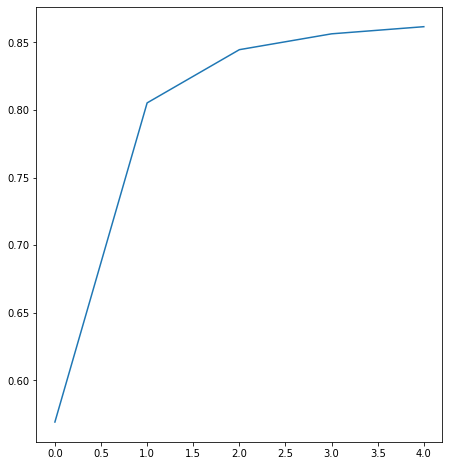

In [25]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

We can further improve the inference on new sentences by improving the way we present the predicted results.

In [ ]:
# prediction is >= 0.0 --> positive review
# else --> negative review

inputs = [
    "This is a fantastic movie.",
    "This is a bad movie.",
    "This movie was so bad that it was good.",
    "I will never say yes to watching this movie.",
    "Skip this movie.",
    "Don't waste your time.",
]

predicted_scores = model.predict(np.array(inputs))
predicted_labels = ["Positive" if x>=0.0 else "Negative" for x in predicted_scores]

for input, label in zip(inputs, predicted_labels):
  print("Question: ", input)
  print("Predicted label: ", label)

## Step 3 -> Assignment: Additional Architectures - Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [ ]:
#step 3
model_2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),

    # Additional layer goes there.
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(..., return_sequences=False), # fill the number of LSTM units in place of ...

    # if you want to add another layer to this network, remember to set return_sequences=True
    # in the previous layer. We want the a multi-layer LSTM network to return the sequences to the
    # following LSTM layer.
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
#step 4
history_2 = model_2.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

In [ ]:
#step 5
test_loss_2, test_acc_2 = model_2.evaluate(test_dataset)

print('Test Loss:', test_loss_2)
print('Test Accuracy:', test_acc_2)

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions_2 = model_2.predict(np.array([sample_text]))
print(predictions_2)

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history_2, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history_2, 'loss')

In [ ]:
# 0 --> negative review
# 1 --> positive review
inputs = [
    "This is a fantastic movie.",
    "This is a bad movie.",
    "This movie was so bad that it was good.",
    "I will never say yes to watching this movie.",
    "Skip this movie.",
    "Don't waste your time.",
]

predicted_scores_2 = model_2.predict(inputs)
predicted_labels_2 = ["Positive" if x>=0.0 else "Negative" for x in predicted_scores_2]

for input, label in zip(inputs, predicted_labels_2):
  print("Question: ", input)
  print("Predicted label: ", label)